In [1]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
%matplotlib inline

# settings
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    
    jitterTolerance=1.0,
    barnesHutOptimize=True, 
    barnesHutTheta=1.2, 
    multiThreaded=False,
    
    scalingRatio=1.0, 
    strongGravityMode=True, 
    gravity=.5,
    
    # Log
    verbose=True)

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
sum([230,225,225,198,267,165,190])

1500

In [4]:
G = nx.random_partition_graph([230,225,225,198,267,165,190], .44, .1)

In [767]:
G = nx.random_partition_graph([10,15,20,10,26,19], .4, .08)

In [785]:
G = nx.random_partition_graph([230,225,225,198,267,165,190, 230,225,225,198,267,165,190], .4, .08)

In [5]:
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations =500)

100%|██████████| 500/500 [00:05<00:00, 96.73it/s] 

BarnesHut Approximation  took  2.20  seconds
Repulsion forces  took  1.90  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.76  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


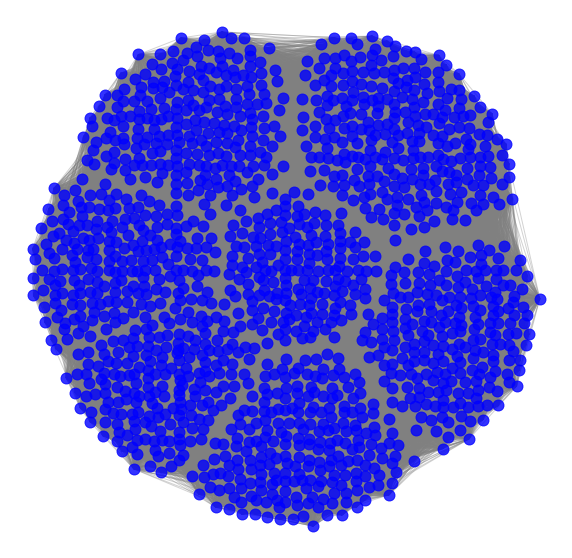

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       nodelist= set(list(G.nodes)),
                       node_size = 120, 
                       node_color = 'Blue', 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)

#labels = {hub:hub for hub in hubs}
#nx.draw_networkx_labels(G, pos, font_size=17, font_color='black')

#labels = {outlier:outlier for outlier in outliers}
#nx.draw_networkx_labels(G_fb, pos, labels=labels, font_size=12, font_color='orange')
plt.axis('off');

In [7]:
len(G.nodes())

1500

In [8]:
import random
random_nodes1 = random.sample(range(len(G.nodes())),int(len(G.nodes())*.15))

In [9]:
bipartite_node = random_nodes1

In [10]:
edge_list = list(zip(*list(zip(*nx.to_edgelist(G)))[:2]))

In [11]:
edge_list = pd.DataFrame(edge_list, columns=['Source','Target'])
edge_list2 = edge_list[['Target','Source']].rename(columns={'Target':'Source','Source':'Target'})
edge_list = pd.concat([edge_list, edge_list2], axis=0)
edge_list = edge_list[[source not in bipartite_node for source in edge_list.Source ]]
bipartite_net = pd.merge(edge_list, pd.DataFrame(bipartite_node, columns=['Target']))

In [12]:
user_nodes = list(set(bipartite_net.Source))

In [13]:
edge_list3 = pd.merge(edge_list2, pd.DataFrame(user_nodes,columns=['Target']))
user_net = pd.merge(edge_list3, pd.DataFrame(user_nodes,columns=['Source']))

In [14]:
bipartite_graph = nx.from_pandas_edgelist(bipartite_net, 'Source', 'Target', create_using=nx.DiGraph())
user_graph = nx.from_pandas_edgelist(user_net, 'Source', 'Target', create_using=nx.Graph())

In [15]:
bipartite_nodes_order = np.array(bipartite_graph.nodes())
bipartite_adj = nx.adjacency_matrix(bipartite_graph, bipartite_nodes_order)

In [16]:
rowsum = bipartite_adj.sum(axis=1)
colsum = bipartite_adj.sum(axis=0)
filter_row = rowsum>0
filter_row= np.array(filter_row).reshape((filter_row.shape[0],))
filter_col = colsum>0
filter_col = np.array(filter_col).reshape(((filter_col.shape[1]),))
bipartite_adj = bipartite_adj[:,filter_col]
bipartite_adj = bipartite_adj[filter_row,]

In [17]:
bipartite_adj.shape

(1275, 225)

In [18]:
# rows :users
bipartite_nodes_order_row = bipartite_nodes_order[filter_row]
# cols: targets
bipartite_nodes_order_col = bipartite_nodes_order[filter_col]

In [19]:
len(bipartite_nodes_order_row)

1275

In [20]:
filter_size = 0
user_fitlter = (bipartite_adj.sum(axis=1).A.reshape(1,-1)>filter_size)[0]
bipartite_adj2 = bipartite_adj[user_fitlter,:]
# rows :users
bipartite_nodes_order_row = bipartite_nodes_order_row[user_fitlter]

In [21]:
bipartite_adj2.shape

(1275, 225)

In [22]:
user_adj = nx.adjacency_matrix(user_graph, bipartite_nodes_order_row)

In [27]:
def calculate_denum(target_node_index, sum_node_edge, target_neighbor_node_sim_mat, target_neighbor_sim_mat,bipartite_adj):
    if target_node_index%500==0:
        print(target_node_index)
    return csr_matrix(sum_node_edge[target_node_index]*sum_node_edge.T*(target_neighbor_sim_mat[target_node_index,:]>0).A)

def num_edge_in_egonet_among_neighbors(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    # Find neighbors : Binary array with the same length of sources
    neighbors = bipartite_adj.T[target_node_index,:].nonzero()[1]
    
    # Return the sum of edges in the general network.
    # Divide by two as they appear in the adjacency matrix 2 times
    # It is always an integer
    return np.int(np.sum(general_adj[:,neighbors][neighbors,])/2)

def target_ego_edge_similarity_2(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    # Find the similarity of edge in ego network of target_index and all other targets
    ego_net_edge_similarty = (np.sum(bipartite_adj.T.multiply((bipartite_adj.T[target_node_index,:].A>0)[0]).dot(general_adj).multiply(bipartite_adj.T.multiply((bipartite_adj.T[target_node_index,:].A>0)[0])),axis=1).T / 2).astype(int)
    return csr_matrix(ego_net_edge_similarty)

def target_ego_edge_similarity(target_node_index, bipartite_adj, general_adj):
    if target_node_index%500==0:
        print(target_node_index)
    temp = bipartite_adj.copy()
    temp = scipy.sparse.csc_matrix(temp)
    # temp[:,target_node_index].A : who are the followers in of target_index
    temp.data += np.take(temp[:,target_node_index].A, temp.indices)
    # Find the similarity of edge in ego network of target_index and all other targets
    ego_net_edge_similarty = (np.sum((temp == 2).T.dot(general_adj).multiply((temp == 2).T),axis=1).T / 2).astype(int)
    return csr_matrix(ego_net_edge_similarty)

def find_SimMat_for_Targets(bipartite_adj, general_adj, agents = 2, chunksize =3):
    target_neighbors_node_count_vector = np.array(bipartite_adj.sum(axis=0)).reshape(-1)
    print("DONE1")
    with Pool(processes = agents) as pool:
        # prepare the num_edge_in_egonet_among_neighbors for accepting several inputs, only one change
        pool_function = partial(num_edge_in_egonet_among_neighbors, bipartite_adj = bipartite_adj, general_adj =general_adj )
        # bipartite_adj.shape[1] is the number of targets
        res = pool.map(pool_function,range(bipartite_adj.shape[1]), chunksize)
    target_neighbors_edge_count_vector = np.array(res)
    del res
    print("DONE2")
    # number of common friends (node)
    target_neighbor_node_sim_mat = bipartite_adj.T.dot(bipartite_adj)
    target_neighbor_node_sim_mat = target_neighbor_node_sim_mat.tocsr()
    print("DONE3")
    # Create the matrix of edge similarity among neighbors of targets
    target_neighbor_edge_sim_mat = csr_matrix((bipartite_adj.shape[1],bipartite_adj.shape[1]), dtype=int)
    target_neighbor_edge_sim_mat = target_neighbor_edge_sim_mat.tolil()
    with Pool(processes = agents) as pool:
        # prepare the target_ego_edge_similarity for accepting several inputs, only one change
        pool_function = partial(target_ego_edge_similarity, bipartite_adj = bipartite_adj, general_adj =general_adj )
        # bipartite_adj.shape[1] is the number of targets
        res = pool.map(pool_function,range(bipartite_adj.shape[1]), chunksize)
    print("DONE4")
    for index, item in enumerate(res):
        if index%500==0:
            print(index)
        target_neighbor_edge_sim_mat[index,:] = item
    del res
    target_neighbor_edge_sim_mat = target_neighbor_edge_sim_mat.tocsr()
    
    print("DONE5")
    # simlifying
    target_neighbor_sim_mat = target_neighbor_node_sim_mat + target_neighbor_edge_sim_mat
    sum_node_edge = target_neighbors_node_count_vector + target_neighbors_edge_count_vector
    sum_node_edge = sum_node_edge.reshape(-1,1)

    denum = sum_node_edge.dot(sum_node_edge.T)
    denum[target_neighbor_sim_mat.A == 0] = 0
    denum = csr_matrix(denum)
    print("DONE6")
    
    # let's use the log version of the similarity
    denum_log_data = np.log(denum.data)
    target_neighbor_sim_mat.data = 2 * np.log(target_neighbor_sim_mat.data) - denum_log_data
    target_neighbor_sim_mat.data = np.exp(target_neighbor_sim_mat.data)
    print("DONE7")
    # target_neighbor_sim_mat becomes the overall similarity
    return target_neighbor_sim_mat

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from scipy.sparse import csr_matrix
from multiprocessing import Pool
from functools import partial

In [29]:
user_adj

<1275x1275 sparse matrix of type '<class 'numpy.longlong'>'
	with 242528 stored elements in Compressed Sparse Row format>

In [30]:
sim_mat = find_SimMat_for_Targets(bipartite_adj2, user_adj, agents = 2, chunksize =10)

DONE1
0
DONE2
DONE3
0
DONE4
0
DONE5
DONE6
DONE7


In [31]:
def cluster_method(i):
    if i%200==0:
        print(i)
    partition = louvain.find_partition(g, louvain.SurpriseVertexPartition, weights='weight');
    return (i,partition.quality(), partition.membership)

In [32]:
import louvain
import igraph as ig

sim_mat = sim_mat.tolil()
sim_mat.setdiag(0) 

A = sim_mat.A
g = ig.Graph.Adjacency((A > 0).tolist())
g.es['weight'] = A[A.nonzero()]
g.vs['label'] = bipartite_nodes_order_col

In [33]:
quality = 0
quyalityList = []
partitionList = []
for i in range(50):
    partition = louvain.find_partition(g, louvain.SurpriseVertexPartition, weights='weight');
    quyalityList.append(partition.quality())
    partitionList.append(partition.membership)
    print("Loop {}: Quality = {}".format(i,partition.quality()))
    if partition.quality() > quality:
        quality = partition.quality()
        bestPartition = partition
        print("Imporved")

Loop 0: Quality = 117.30351893449858
Imporved
Loop 1: Quality = 117.30351893449858
Loop 2: Quality = 117.30351893449858
Loop 3: Quality = 117.30351893449858
Loop 4: Quality = 117.30351893449858
Loop 5: Quality = 117.30351893449858
Loop 6: Quality = 117.30351893449858
Loop 7: Quality = 117.30351893449858
Loop 8: Quality = 117.30351893449858
Loop 9: Quality = 117.30351893449858
Loop 10: Quality = 117.30351893449858
Loop 11: Quality = 117.30351893449858
Loop 12: Quality = 117.30351893449858
Loop 13: Quality = 117.30351893449858
Loop 14: Quality = 117.30351893449858
Loop 15: Quality = 117.30351893449858
Loop 16: Quality = 117.30351893449858
Loop 17: Quality = 117.30351893449858
Loop 18: Quality = 117.30351893449858
Loop 19: Quality = 117.30351893449858
Loop 20: Quality = 117.30351893449858
Loop 21: Quality = 117.30351893449858
Loop 22: Quality = 117.30351893449858
Loop 23: Quality = 117.30351893449858
Loop 24: Quality = 117.30351893449858
Loop 25: Quality = 117.30351893449858
Loop 26: Qual

In [34]:
sim_mat.setdiag(1)
membership = np.array(bestPartition.membership)
cluster_size = len(set(membership))

In [35]:
clusterMat = np.zeros((cluster_size,len(membership)))
for i in range(cluster_size):
    mask = (membership == i)
    clusterMat[i,mask] = 1
clusterMat = csr_matrix(clusterMat.T @ clusterMat)

In [36]:
inside_weights = (clusterMat.multiply(sim_mat)).sum(axis=0)
overall_weights = sim_mat.sum(axis=0)
weights = np.array(inside_weights/overall_weights)
dat = pd.DataFrame(np.array([bipartite_nodes_order_col,np.array(bestPartition.membership),weights[0]]).T, columns=['Members','Cluster','weights']) 
dat.head()

,Members,Cluster,weights
0,20.0,2.0,0.937929
1,22.0,2.0,0.913156
2,38.0,2.0,0.919187
3,104.0,2.0,0.936441
4,105.0,2.0,0.918248


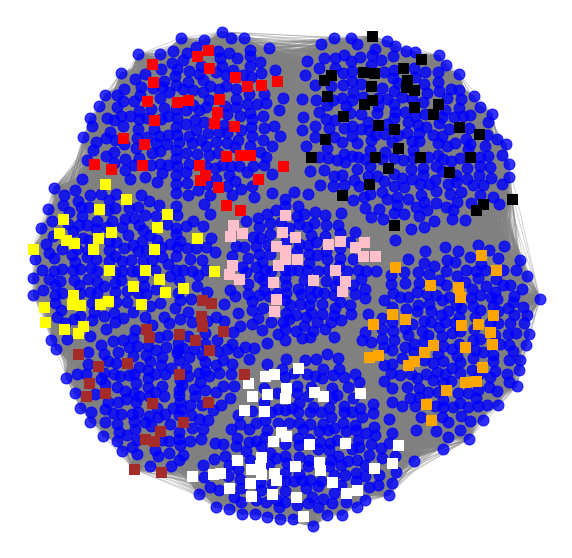

In [39]:
colors={0:'white', 1:'black',2:'red', 3:'yellow',4:'orange',5:'pink',6:'brown',7:'grey',8:'gold', 9:'purple', 10:'teal', 11:'green', 12:'silver'}

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       nodelist= set(list(G.nodes)) - set(dat.Members),
                       node_size = 120, 
                       node_color = 'Blue', 
                       alpha=0.8)

for cluster in range(cluster_size):
    nodes = list(dat[dat.Cluster==cluster].Members)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= nodes,
                       node_size = 120, 
                       node_color = colors[cluster],
                       node_shape = 's',
                       alpha=1)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)

#labels = {hub:hub for hub in hubs}
#nx.draw_networkx_labels(G, pos, font_size=17, font_color='black')

#labels = {outlier:outlier for outlier in outliers}
#nx.draw_networkx_labels(G_fb, pos, labels=labels, font_size=12, font_color='orange')
plt.axis('off');

In [40]:
clusterMat = np.zeros((cluster_size,len(dat.Cluster)))
for i in range(cluster_size):
    mask = (dat.Cluster == i)
    clusterMat[i,mask] = dat.weights[mask]

In [41]:
colnames_embedding = list()
for i in range(cluster_size) :
    name = "E"+str(i)
    colnames_embedding.append(name)

In [42]:
sumWeights = clusterMat.sum(axis=1,keepdims=True)
#normalize
cluster_mat = clusterMat / sumWeights

In [43]:
new_bipartite_adj = nx.adjacency_matrix(G, range(len(G.nodes)))
new_bipartite_adj = new_bipartite_adj.tolil()
new_bipartite_adj.setdiag(1)

In [44]:
new_bipartite_adj = new_bipartite_adj[:,bipartite_nodes_order_col]

In [45]:
new_bipartite_adj.shape

(1500, 225)

In [46]:
cluster_mat.shape

(7, 225)

In [47]:
user_embedding = new_bipartite_adj.dot(cluster_mat.T)
user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)

In [48]:
# adj = nx.adjacency_matrix(G, range(len(G.nodes)))
# adj.setdiag(1)
# user_embedding = adj.dot(user_embedding)/adj.sum(axis=1)
# user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)

In [49]:
#user_embedding = pd.DataFrame(user_embedding, index=range(len(G.nodes)), columns=colnames_embedding)
user_embedding.head()

,E0,E1,E2,E3,E4,E5,E6
0,0.093386,0.055495,0.423211,0.060567,0.110880,0.036494,0.152542
1,0.092468,0.139193,0.485201,0.122052,0.184501,0.075075,0.038574
2,0.069895,0.054922,0.424733,0.091919,0.036876,0.073657,0.077864
3,0.139678,0.138455,0.393595,0.120411,0.036966,0.110618,0.114462
4,0.115723,0.055382,0.422321,0.151165,0.110878,0.036623,0.191498


In [50]:
user_embedding = user_embedding.reset_index()

In [51]:
user_embedding.head()

,index,E0,E1,E2,E3,E4,E5,E6
0,0,0.093386,0.055495,0.423211,0.060567,0.110880,0.036494,0.152542
1,1,0.092468,0.139193,0.485201,0.122052,0.184501,0.075075,0.038574
2,2,0.069895,0.054922,0.424733,0.091919,0.036876,0.073657,0.077864
3,3,0.139678,0.138455,0.393595,0.120411,0.036966,0.110618,0.114462
4,4,0.115723,0.055382,0.422321,0.151165,0.110878,0.036623,0.191498


In [52]:
X = user_embedding.drop('index',axis=1)

In [53]:
X.shape

(1500, 7)

In [54]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=7, random_state=0)
kmeans_model.fit(X)
y_kmeans = kmeans_model.predict(X)

In [55]:
clustering_result = pd.DataFrame(np.array([np.array(range(len(G.nodes))), y_kmeans]).T, columns=['member','cluster'])

In [56]:
clustering_result.head()

,member,cluster
0,0,3
1,1,3
2,2,3
3,3,3
4,4,3


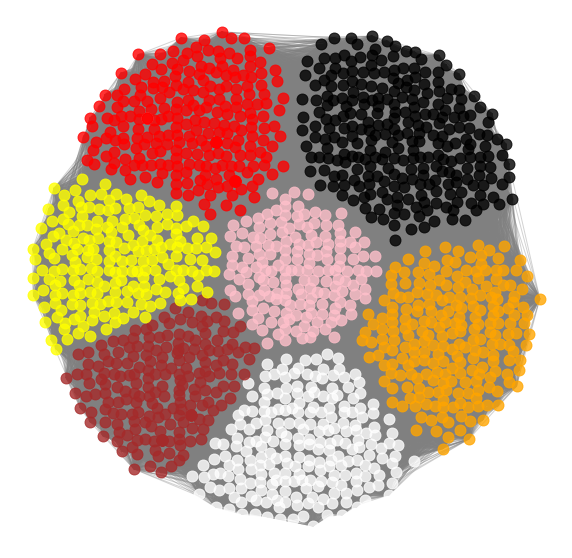

In [101]:
colors={0:'black', 1:'white',2:'orange', 3:'red',4:'brown',5:'pink',6:'yellow',7:'grey',8:'gold', 9:'purple', 10:'teal', 11:'green', 12:'silver'}

fig, ax = plt.subplots(figsize=(10, 10))

cluster_size = len(set(dat.Cluster))

for cluster in range(7):
    nodes = list(clustering_result[clustering_result.cluster==cluster].member)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= set(nodes) ,
                       node_size = 120, 
                       node_color = colors[cluster], 
                       alpha=0.8)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= [36,60,68],
                       node_size = 120, 
                       node_color = 'red', 
                       alpha=0.8)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= range(1390,1392),
                       node_size = 120, 
                       node_color = 'brown', 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)
plt.axis('off');

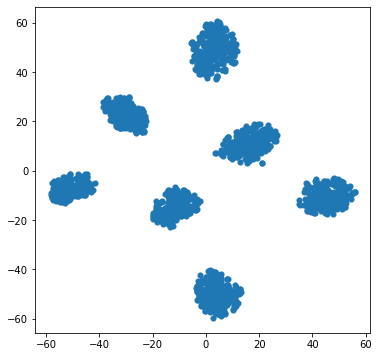

In [102]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(6, 6))

tsne = TSNE(n_components=2, random_state=0) 
projection = tsne.fit_transform(X)
plt.scatter(projection[:, 0], projection[:, 1], lw=0.1) 

plt.show()

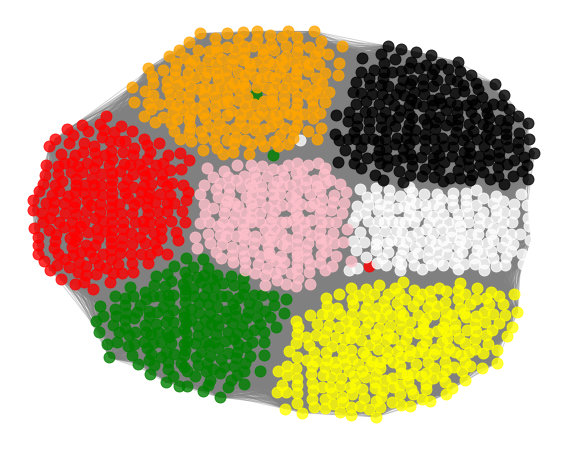

In [105]:
colors={0:'red', 1:'green',2:'white', 3:'orange',4:'yellow',5:'black',6:'pink'}

fig, ax = plt.subplots(figsize=(10, 8))

cluster_size = len(set(dat.Cluster))

for cluster in range(7):
    nodes = list(clustering_result[clustering_result.cluster==cluster].member)
    nx.draw_networkx_nodes(G, pos,
                       nodelist= nodes,
                       node_size = 120, 
                       node_color = colors[cluster], 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)
plt.axis('off');

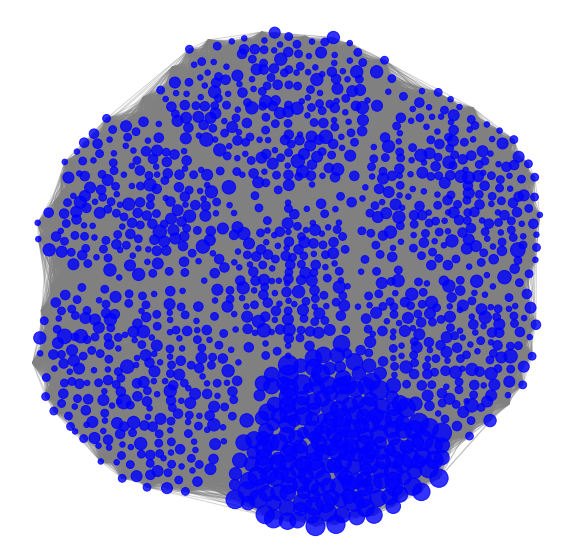

In [367]:
colors={0:'red', 1:'green',2:'white', 3:'orange',4:'yellow',5:'black',6:'pink'}

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       nodelist= set(list(G.nodes)),
                       node_size = user_embedding.E3*640, 
                       node_color = 'Blue', 
                       alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color="grey", alpha=0.35)

#labels = {hub:hub for hub in hubs}
#nx.draw_networkx_labels(G, pos, font_size=17, font_color='black')

#labels = {outlier:outlier for outlier in outliers}
#nx.draw_networkx_labels(G_fb, pos, labels=labels, font_size=12, font_color='orange')
plt.axis('off');